In [8]:
import pandas as pd

# CSV 파일 불러오기

data = pd.read_csv('D:/장우영/LOCALSEARCH/Ship_DA/DA/data/FAmerge_20230607_114714.csv', encoding='ANSI')

# B열 값을 A열의 값으로 변환
data['일시'] = data['insert_time']

print(data.일시)
print(data.insert_time)

0         2023-05-11 10:10:58
1         2023-05-11 10:10:58
2         2023-05-11 10:10:58
3         2023-05-11 10:10:58
4         2023-05-11 10:10:58
                 ...         
437121    2023-05-11 23:59:59
437122    2023-05-11 23:59:59
437123    2023-05-11 23:59:59
437124    2023-05-11 23:59:59
437125    2023-05-11 23:59:59
Name: 일시, Length: 437126, dtype: object


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import binascii
from shapely import wkb
import pyproj
from pyproj import Transformer

def convert_wkb_to_coordinates(wkb_string):
    
    # 0단계 :Check if the value is a float
    if isinstance(wkb_string, float):
        return None, None
    
    # 1단계: 16진수 문자열을 이진 형식으로 디코딩
    binary_string = binascii.unhexlify(wkb_string)

    # 2단계: 이진 형식 파싱
    geometry = wkb.loads(binary_string)

    # 3단계: 좌표를 위도와 경도로 변환
    if geometry and hasattr(geometry, 'wkt'):
        # Well-Known Text (WKT) 형식으로 변환
        wkt = geometry.wkt

        # 좌표 시스템 변환 정의
        #!crs_from = pyproj.Proj(init='epsg:3857')
        #!crs_to = pyproj.Proj(init='epsg:4326')
        transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")
        #transformer.transform(12, 12)

        # 좌표 변환 수행
        #! transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)
        transformed = Transformer.transform(transformer,geometry.x, geometry.y)
   
        # 위도와 경도 추출
        latitude, longitude = transformed[0], transformed[1]
        
        return latitude, longitude
    else:
        return None, None
    
# Load data from CSV file
data = pd.read_csv('D:/장우영/LOCALSEARCH/Ship_DA/DA/data/FAmerge_20230607_114714.csv', encoding='ANSI')

# 특정 칼럼의 조건에 따라 데이터 필터링
filtered_data = data[data['sog'] > 3]  # 특정 칼럼과 조건을 적절히 수정해야 합니다

data= filtered_data

# 좌표 변환 적용 및 데이터프레임 업데이트
data[['latitude', 'longitude']] = data['geom'].apply(convert_wkb_to_coordinates).apply(pd.Series)

# "insert_time"을 숫자로 변환
data['year'] = pd.to_datetime(data['insert_time']).dt.year
data['month'] = pd.to_datetime(data['insert_time']).dt.month
data['day'] = pd.to_datetime(data['insert_time']).dt.day
data['hour'] = pd.to_datetime(data['insert_time']).dt.hour
data['minute'] = pd.to_datetime(data['insert_time']).dt.minute
data['second'] = pd.to_datetime(data['insert_time']).dt.minute

# 특성 선택

X = data[["mmsi", "ship_type", "latitude","longitude", "cog", "sog", "year", "month", "day", "hour", "minute", "second", "풍향", "유향", "기온", "수온", "풍속", "유속", "기압", "습도"]]

print(X)

# 타겟 변수 선택
y_latitude = data["latitude"]  # 원래 데이터셋의 Latitude 값
y_longitude = data["longitude"]  # 원래 데이터셋의 Longitude 값
y_cog = data["cog"]  # 원래 데이터셋의 COG 값
y_sog = data["sog"]  # 원래 데이터셋의 SOG 값

# 데이터를 교육 및 테스트 세트로 분할
X_train, X_test, y_latitude_train, y_latitude_test, y_longitude_train, y_longitude_test, y_cog_train, y_cog_test, y_sog_train, y_sog_test = train_test_split(
    X, y_latitude, y_longitude, y_cog, y_sog, test_size=0.2, random_state=42
)

# Latitude 모델 훈련 및 예측
model_latitude = GradientBoostingRegressor()
model_latitude.fit(X_train, y_latitude_train)
y_latitude_pred = model_latitude.predict(X_test)

# Longitude 모델 훈련 및 예측
model_longitude = GradientBoostingRegressor()
model_longitude.fit(X_train, y_longitude_train)
y_longitude_pred = model_longitude.predict(X_test)

# COG 모델 훈련 및 예측
model_cog = GradientBoostingRegressor()
model_cog.fit(X_train, y_cog_train)
y_cog_pred = model_cog.predict(X_test)

# SOG 모델 훈련 및 예측
model_sog = GradientBoostingRegressor()
model_sog.fit(X_train, y_sog_train)
y_sog_pred = model_sog.predict(X_test)

# 정확도 예측
mse_latitude = mean_squared_error(y_latitude_test, y_latitude_pred)
mse_longitude = mean_squared_error(y_longitude_test, y_longitude_pred)
mse_cog = mean_squared_error(y_cog_test, y_cog_pred)
mse_sog = mean_squared_error(y_sog_test, y_sog_pred)

# 예측된 Latitude, Longitude, COG, SOG 값을 출력
print("Predicted Latitude:", y_latitude_pred)
print("Predicted Longitude:", y_longitude_pred)
print("Predicted COG:", y_cog_pred)
print("Predicted SOG:", y_sog_pred)

# 정확도 예측
print("MSE Latitude:", mse_latitude)
print("MSE Longitude:", mse_longitude)
print("MSE COG:", mse_cog)
print("MSE SOG:", mse_sog)


             mmsi  ship_type   latitude   longitude    cog   sog  year  month   
0       440051540          0  35.039909  129.062547  329.2   5.7  2023      5  \
5       538010219          0  34.882612  129.060553  212.2  16.1  2023      5   
17      440051540          0  35.039909  129.062547  329.2   5.7  2023      5   
19      440102990          0  35.099860  129.041436   42.6   8.8  2023      5   
20      440048210         80  35.064618  129.110167   31.6   9.6  2023      5   
...           ...        ...        ...         ...    ...   ...   ...    ...   
437107  403643000         80  35.098633  129.369357   26.5  11.9  2023      5   
437108  441163000          0  34.395000  130.250605  306.8  11.7  2023      5   
437110  440155350         80  35.076044  129.108846   13.9  10.4  2023      5   
437111  440124000         78  35.064802  129.120264  147.1   9.9  2023      5   
437112  563157300         74  35.212664  129.377829   15.0  10.6  2023      5   

        day  hour  minute  

In [ ]:
import pickle

# 모델 저장
with open('model_latitude.pkl', 'wb') as f:
    pickle.dump(model_latitude, f)

with open('model_longitude.pkl', 'wb') as f:
    pickle.dump(model_longitude, f)
    
with open('model_cog.pkl', 'wb') as f:
    pickle.dump(model_cog, f)

with open('model_sog.pkl', 'wb') as f:
    pickle.dump(model_sog, f)

# 모델 불러오기
with open('model_latitude.pkl', 'rb') as f:
    model_latitude = pickle.load(f)

with open('model_longitude.pkl', 'rb') as f:
    model_longitude = pickle.load(f)
    
with open('model_cog.pkl', 'rb') as f:
    model_cog = pickle.load(f)

with open('model_sog.pkl', 'rb') as f:
    model_sog = pickle.load(f)    

MSE Latitude: 8.141836418187882e-06

위도(Latitude)의 예측 값과 실제 값 사이의 평균 제곱 오차(MSE)는 매우 작은 값입니다. 이는 모델이 위도를 정확하게 예측하는 데 성공했음을 나타냅니다.
MSE Longitude: 2.2479064275089946e-05

경도(Longitude)의 예측 값과 실제 값 사이의 MSE는 위도에 비해 크지만 여전히 매우 작은 값입니다. 따라서 모델은 경도를 상당히 정확하게 예측할 수 있었을 것으로 보입니다.
MSE COG: 0.4436597293301889

COG(선속방향)의 예측 값과 실제 값 사이의 MSE는 상대적으로 큰 값입니다. 이는 모델이 COG를 예측하는 데 어려움을 겪었을 가능성이 있습니다. COG는 다른 특성들에 비해 예측하기 어려운 변수일 수 있습니다.
MSE SOG: 0.000632866761406288

SOG(선속)의 예측 값과 실제 값 사이의 MSE는 COG보다는 작지만 여전히 상당한 값입니다. 모델이 SOG를 상대적으로 정확하게 예측하지 못했을 가능성이 있습니다.
분석 결과, 위도와 경도의 예측 값의 MSE가 매우 작아 정확한 예측이 이루어졌지만, COG와 SOG의 예측 값의 MSE가 상대적으로 크므로 해당 변수들을 예측하는 데는 아직 개선의 여지가 있을 수 있습니다. 추가적인 데이터 처리나 모델 튜닝 등을 통해 모델의 성능을 더욱 개선할 수 있을 것입니다. -->

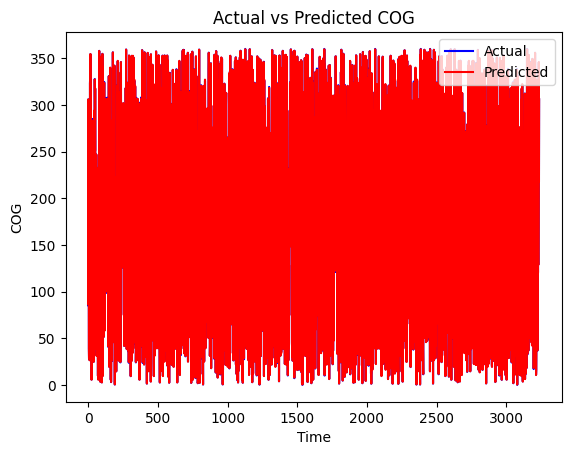

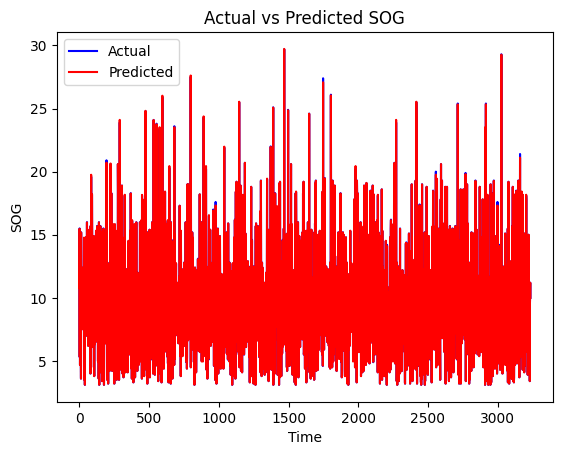

In [5]:
import matplotlib.pyplot as plt

# Create a time axis based on the index of the test data
time_axis = range(len(y_cog_test))

# Visualize COG predictions
plt.plot(time_axis, y_cog_test, color='blue', label='Actual')
plt.plot(time_axis, y_cog_pred, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('COG')
plt.title('Actual vs Predicted COG')
plt.legend()
plt.show()

# Visualize SOG predictions
plt.plot(time_axis, y_sog_test, color='blue', label='Actual')
plt.plot(time_axis, y_sog_pred, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('SOG')
plt.title('Actual vs Predicted SOG')
plt.legend()
plt.show()


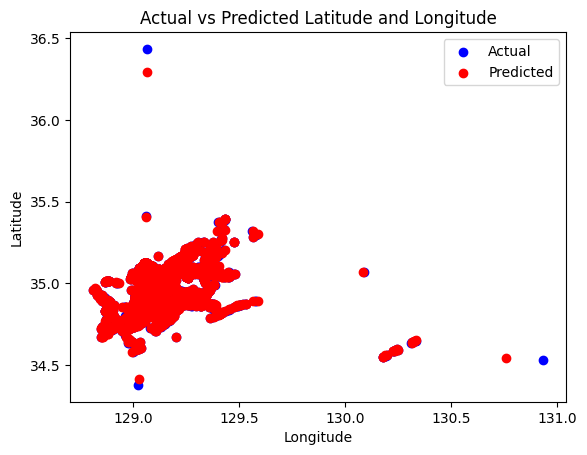

In [6]:
import matplotlib.pyplot as plt

# Visualize latitude and longitude predictions
plt.scatter(y_longitude_test, y_latitude_test, color='blue', label='Actual')
plt.scatter(y_longitude_pred, y_latitude_pred, color='red', label='Predicted')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted Latitude and Longitude')
plt.legend()
plt.show()


In [ ]:
# GradientBoostingRegressor는 Gradient Boosting 알고리즘을 기반으로 한 회귀 모델입니다. Gradient Boosting은 앙상블 기법 중 하나로, 여러 개의 약한 학습기(weak learner)를 결합하여 강력한 학습기를 만드는 방법입니다.

# GradientBoostingRegressor는 이러한 Gradient Boosting 알고리즘을 회귀 문제에 적용한 모델입니다. 이 모델은 기본적으로 결정 트리(Decision Tree)를 약한 학습기로 사용하여 예측을 수행합니다. Gradient Boosting 알고리즘은 이전 학습기의 오차를 보완하는 방식으로 학습을 진행하며, 예측과 실제 값 사이의 잔차(residual)를 줄여나가는 방향으로 모델을 업데이트합니다.

# GradientBoostingRegressor의 주요 특징은 다음과 같습니다:

# 앙상블 학습 기법 중 하나인 Gradient Boosting을 기반으로 한다는 점입니다.
# 여러 개의 결정 트리(weak learner)를 사용하여 예측을 수행하고, 이를 결합하여 강력한 회귀 모델을 구성합니다.
# 이전 학습기의 예측 결과와 실제 값 사이의 잔차를 최소화하는 방식으로 모델을 학습합니다.
# 오차 함수로 평균 제곱 오차(Mean Squared Error, MSE)를 사용하여 모델을 평가합니다.
# GradientBoostingRegressor는 데이터의 특징을 자동으로 학습하고 예측할 수 있는 능력이 강력하며, 과적합을 줄이기 위한 다양한 매개변수를 제공합니다. 또한, 회귀 문제에서도 잘 작동하는 것으로 알려져 있습니다.

# 하지만, GradientBoostingRegressor는 학습 및 예측 속도가 상대적으로 느리고, 모델의 복잡성과 메모리 사용량이 크다는 단점이 있을 수 있습니다. 또한, 매개변수 튜닝이 필요할 수 있으며, 특정 데이터셋에 따라 최적의 성능을 내지 못할 수도 있습니다.

# 따라서, GradientBoostingRegressor를 사용할 때는 데이터의 특성과 모델의 성능, 시간 및 메모리 제약 등을 고려하여 적절한 매개변수 설정과 모델의 훈련 시간을 고려해야 합니다.